# 4. Geophysics Data Fusion Demonstration
Fuses data from a netCDF line dataset, a netCDF grid dataset, and a WCS elevation data web service

In [1]:
%matplotlib inline

In [2]:
import os
import netCDF4
import numpy as np
from geophys_utils import NetCDFGridUtils
from geophys_utils import NetCDFLineUtils
from geophys_utils import get_gdal_wcs_dataset, get_gdal_grid_values # N.B: GDAL WCS won't work on Alex's Windows laptop
import matplotlib.pyplot as plt

In [3]:
# Setup proxy as required
GA_STAFF_WIFI = False

if GA_STAFF_WIFI:
    os.environ['http_proxy'] = 'http://proxy.inno.lan:3128'
    os.environ['https_proxy'] = 'http://proxy.inno.lan:3128'

In [4]:
dem_wcs_url = 'http://services.ga.gov.au/site_9/services/DEM_SRTM_1Second_Hydro_Enforced/MapServer/WCSServer?service=WCS'

line_nc_path = "/iv65/Geoscience_Australia_Geophysics_Reference_Data_Collection/airborne_geophysics/SA/line/P1255/P1255-line-magnetic-Marree-AWAGS_MAG_2010.nc"
if not os.path.isfile(line_nc_path):
    line_nc_path = "https://dapds00.nci.org.au/thredds/dodsC/iv65/Geoscience_Australia_Geophysics_Reference_Data_Collection/airborne_geophysics/SA/line/P1255/P1255-line-magnetic-Marree-AWAGS_MAG_2010.nc"

grid_nc_path = "/iv65/Geoscience_Australia_Geophysics_Reference_Data_Collection/national_geophysical_compilations/Gravmap2019/Gravmap2019-grid-grv_cscba_1vd.nc"
if not os.path.isfile(grid_nc_path):
    grid_nc_path = "https://dapds00.nci.org.au/thredds/dodsC/iv65/Geoscience_Australia_Geophysics_Reference_Data_Collection/national_geophysical_compilations/Gravmap2019/Gravmap2019-grid-grv_cscba_1vd.nc"

bounds = (137, -29, 138, -28) # Bounding box within survey area

In [5]:
# Initialise NetCDFLineUtils object
# Code is at https://github.com/alex-ip/geophys_utils
#line_nc_dataset = netCDF4.Dataset(line_nc_path)
line_nc_dataset = netCDF4.Dataset(line_nc_path + '#fillmismatch') # Note work-around for bad _FillValue: https://github.com/Unidata/netcdf-c/issues/1299
netcdf_line_utils = NetCDFLineUtils(line_nc_dataset)

In [6]:
# Initialise NetCDFGridUtils object
# Code is at https://github.com/alex-ip/geophys_utils
grid_nc_dataset = netCDF4.Dataset(grid_nc_path)
netcdf_grid_utils = NetCDFGridUtils(grid_nc_dataset)

/srv/conda/envs/notebook/lib/python3.10/site-packages/osgeo/osr.py:385: FutureWarning: Neither osr.UseExceptions() nor osr.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [7]:
# Open GDAL dataset for DEM WCS
dem_gdal_dataset = get_gdal_wcs_dataset(dem_wcs_url)

In [8]:
# Get all coordinates and data points for line 100060
line_number, line_dict = next(netcdf_line_utils.get_lines(line_numbers=100060, variables='mag_awagslevelled'))
print(line_number, line_dict)

coordinates = line_dict['coordinates']
mag_awags = line_dict['mag_awagslevelled']

100060 {'coordinates': masked_array(
  data=[[139.52525 , -28.155075],
        [139.525249, -28.155129],
        [139.525248, -28.155183],
        ...,
        [139.504499, -29.616025],
        [139.504498, -29.616085],
        [139.504497, -29.616144]],
  mask=False,
  fill_value=1e+20), 'mag_awagslevelled': masked_array(data=[-97.00695 , -96.980675, -96.95639 , ..., -52.15275 ,
                   -52.166435, -52.175125],
             mask=False,
       fill_value=1e+20,
            dtype=float32)}


In [9]:
# Compute cumulative distances in metres for line 100060
utm_distances = netcdf_line_utils.coords2metres(coordinates)
print(utm_distances.shape, utm_distances)

(25373,) [0.00000000e+00 5.98434645e+00 1.19686929e+01 ... 1.61925609e+05
 1.61932260e+05 1.61938799e+05]


In [10]:
# Obtain values for sample points from gridded dataset
grid_values = np.array(netcdf_grid_utils.get_value_at_coords(coordinates, max_bytes=100))
print(grid_values.shape, grid_values)

(25373,) [ 89.879555  89.879555  89.879555 ... 548.66797  548.66797  548.66797 ]


In [11]:
# Obtain DEM values via WCS
dem_values = get_gdal_grid_values(dem_gdal_dataset, coordinates, netcdf_line_utils.wkt)
print(dem_values.shape, dem_values)

(25373,) [23.400557 23.400557 23.400557 ... 72.32505  72.32505  72.44533 ]


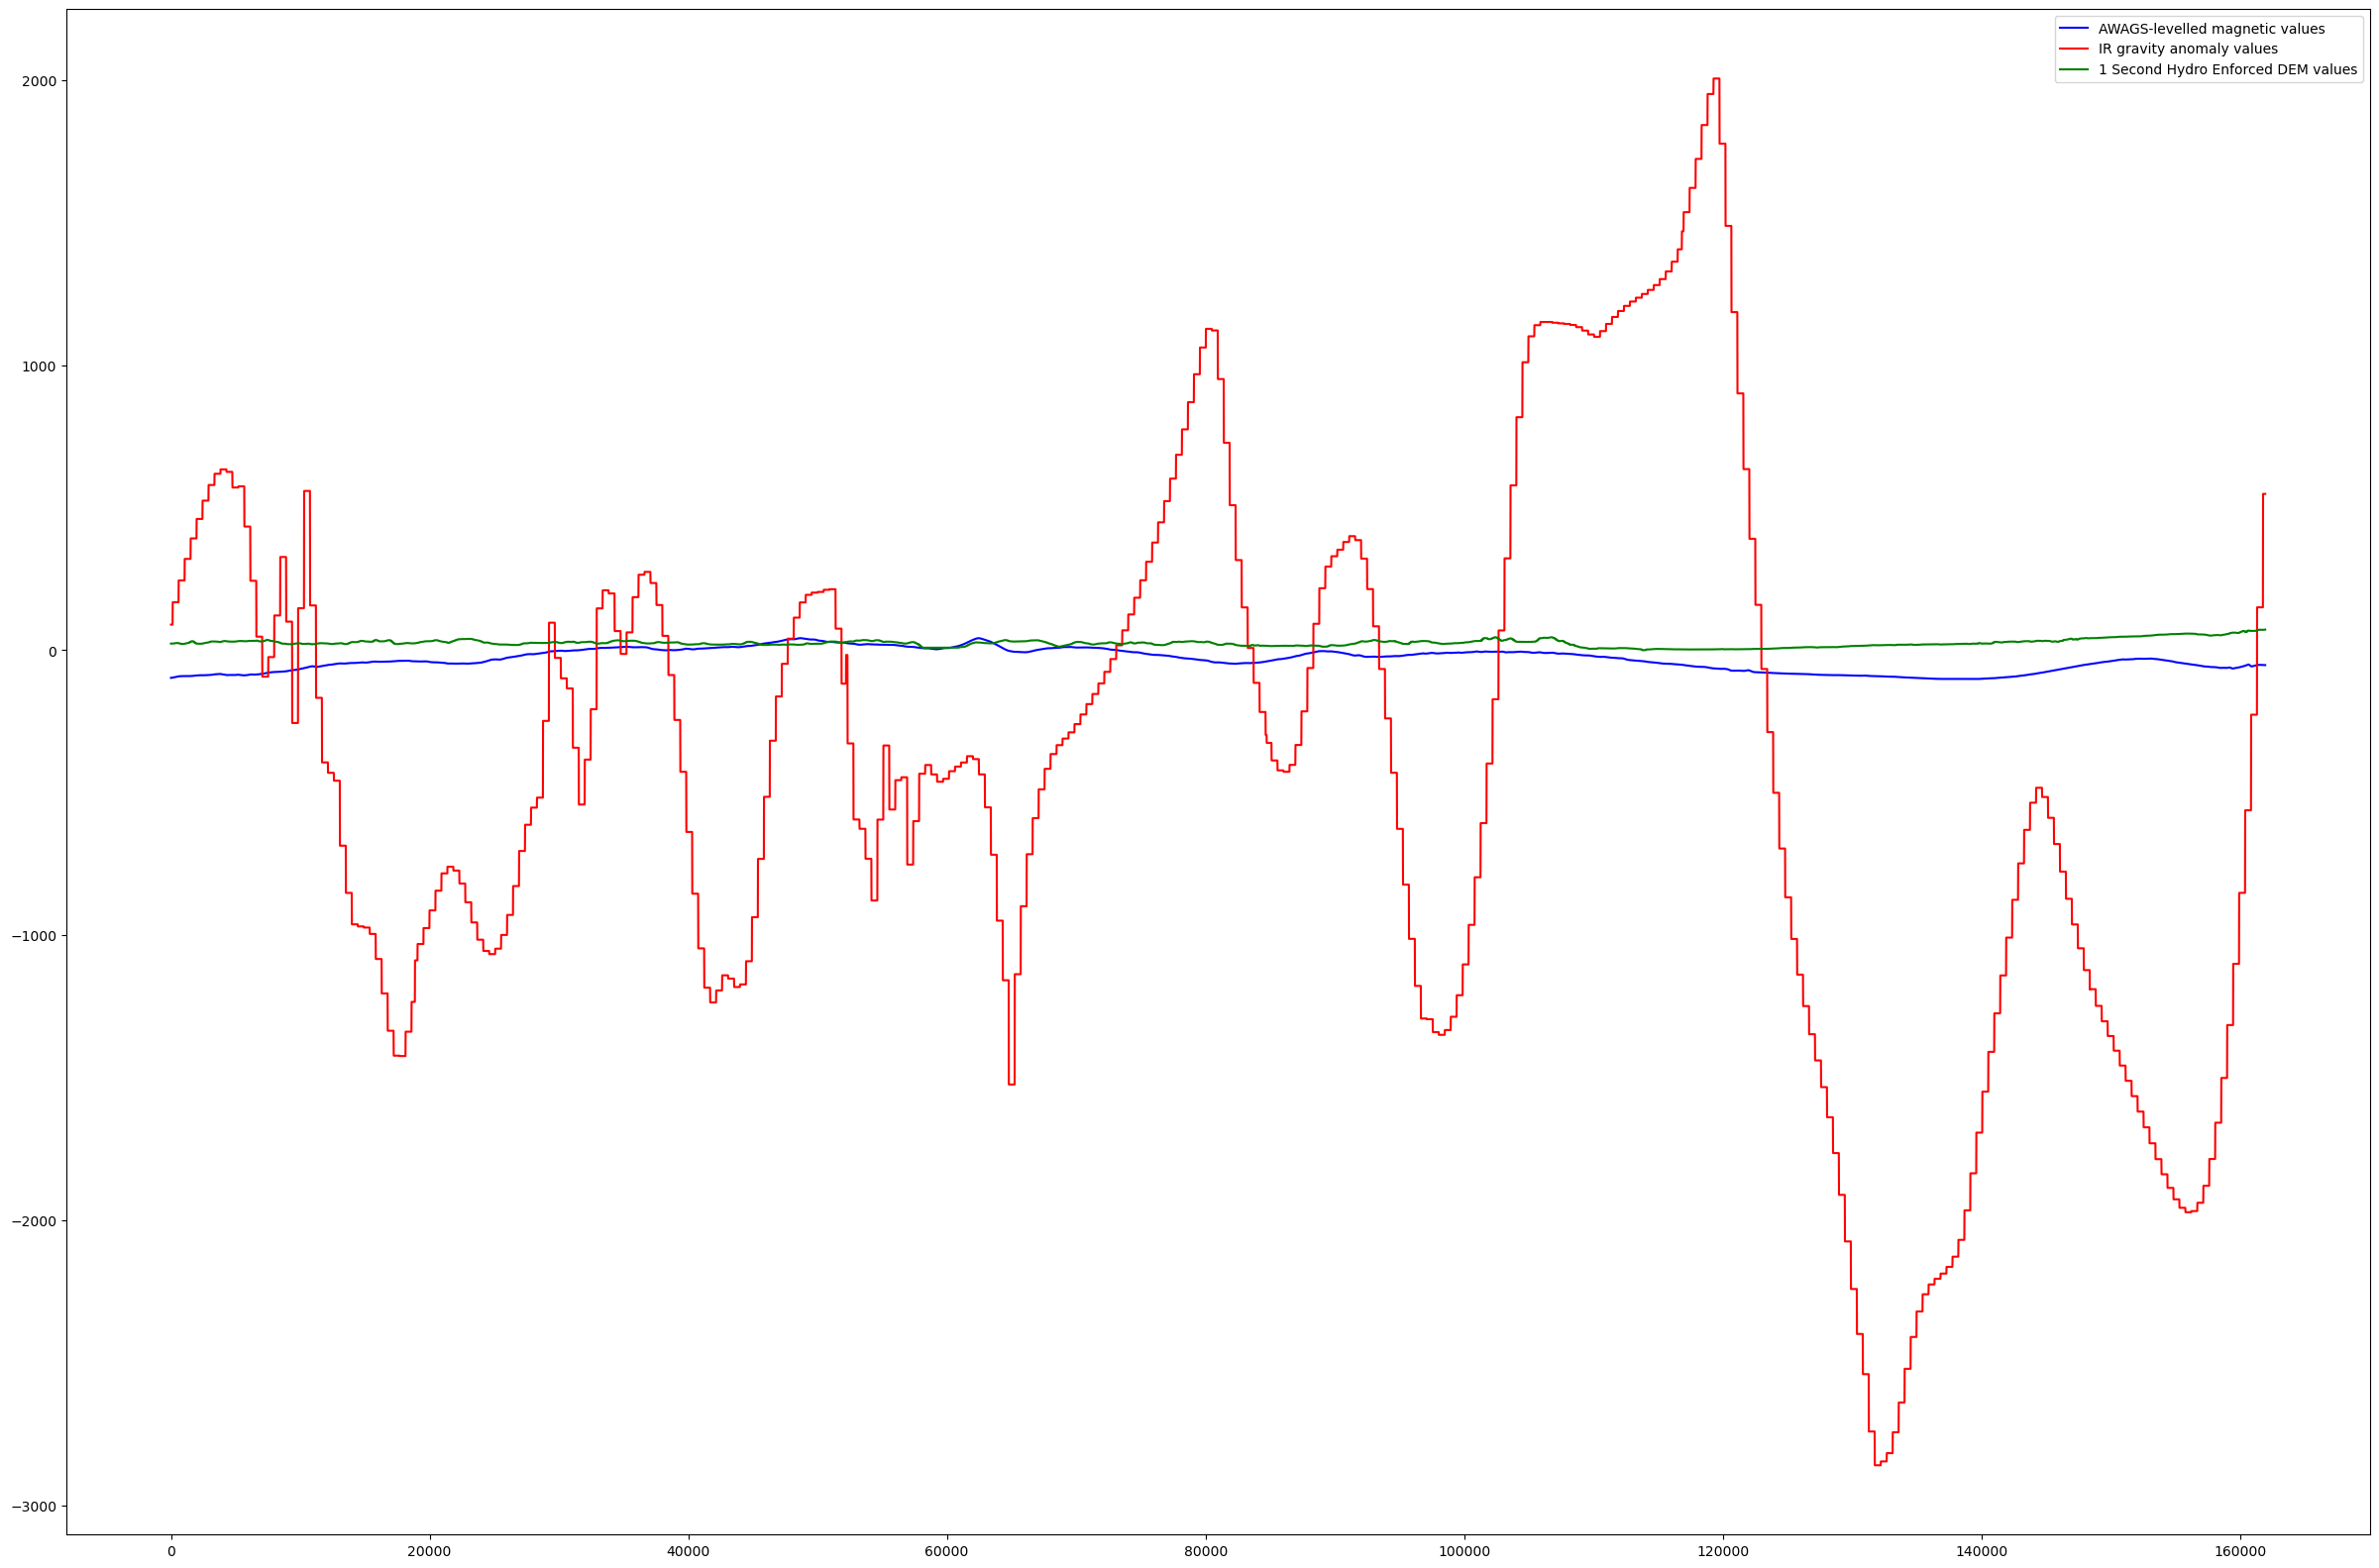

In [12]:
# Plot data points against line distance for line 100060
plt.figure(figsize=(30,20))   
plt.plot(utm_distances, line_dict['mag_awagslevelled'], 'b-', label='AWAGS-levelled magnetic values')        
plt.plot(utm_distances, grid_values, 'r-', label='IR gravity anomaly values')
plt.plot(utm_distances, dem_values, 'g-', label='1 Second Hydro Enforced DEM values')
plt.legend()